In [1]:
# to use for customizing the display/format of the cells
# for more info and resources check these links:
# http://stackoverflow.com/questions/34303422/how-to-change-the-font-size-and-color-of-markdown-cell-in-ipython-py-2-7-noteb
# http://nbviewer.jupyter.org/github/Carreau/posts/blob/master/Blog1.ipynb
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:0.5em;
margin-bottom:0.5em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 1.7em;
line-height:1.1em;
text-align:left;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.1em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.3em;
line-height:1.3em;
padding-left:1em;
padding-right:1em;
}
#pseq_class{
font-weight:bold;
color:blue;
}
#pseq_method{
font-weight:bold;
color:blue;
}
#pseq_attr{
font-weight:bold;
font-style:italic;
}

tr.pseq_border{
 border-bottom:1pt solid black;
 border: 1px solid green;
 padding: 5px;
}


.pseq_class{
font-weight:bold;
color:blue;
}
.pseq_attr{
font-weight:bold;
font-style:italic;
}
.pseq_method{
font-weight:bold;
color:blue;
}
.pseq_args{
font-weight:bold;
}

code.pseq_code{
font-size:0.85em;
}
code.pseq_class{
font-size:0.9em;
font-weight:bold;
color:blue;
}
code.pseq_method{
font-size:0.9em;
font-weight:bold;
color:blue;
}
code.pseq_attr{
font-size:0.85em;
font-weight:bold;
font-style:italic;
}
code.pseq_args{
font-size:0.85em;
font-weight:bold;
}
code.pseq_var{
font-size:0.85em;
}
</style>
""")

# Table of Contents
* [1. Objectives and goals](#1.-Objectives-and-goals)
* [2. Supported models](#2.-Supported-models)
* [3. Model building workflow](#3.-Model-building-workflow)
	* [3.1 Parsing sequences/segments](#3.1-Parsing-sequences/segments)
	* [3.2 Building CRFs model](#3.2-Building-CRFs-model)
	* [3.3 Training CRFs model (i.e. estimating parameters)](#3.3-Training-CRFs-model-%28i.e.-estimating-parameters%29)
		* [3.3.1 Training methods -- optimization options](#3.3.1-Training-methods----optimization-options)
		* [3.3.2 Learning/estimating model parameters](#3.3.2-Learning/estimating-model-parameters)
	* [3.4 Using trained CRFs model](#3.4-Using-trained-CRFs-model)
* [4. Applications](#4.-Applications)
* [5. Reference/literature](#5.-Reference/literature)


# 1. Objectives and goals

In this tutorial, we will learn about:
<ul>
<li> parsing, preparing and representing sequences in a training dataset for model building</li>
<li> the different available CRF models in <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab package</a></li>
<li> the process/workflow for buidling CRF models</li>
</ul>

<strong><em>Reminder</em></strong>: To work with this tutorial interactively, we need first to clone the <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> package to our disk locally and then navigate to <strong>[cloned_package_dir]/tutorials</strong> where <strong>[cloned_package_dir]</strong> is the path to the cloned package folder (see the tree path for display).
<pre style="font-size:0.8em;">
├── pyseqlab
    ├── tutorials
    │   ├── datasets
    │   │   ├── conll2000
    │   │   ├── segments

</pre>

We suggest going through the earlier tutorials:
<ol>
<li>[sequence_and_input_structure tutorial](./sequence_and_input_structure.ipynb)</li>
<li>[templates_and_feature_extraction](templates_and_features_extraction.ipynb)</li>
</ol>

before continuing through this notebook. We will use part of the <a href="http://www.cnts.ua.ac.be/conll2000/chunking/">CoNLL 2000 training dataset</a> throughout this tutorial.

As a <strong><em>reminder</em></strong>, the CoNLL 2000 task states: <blockquote> Given a set of sentences (our sequences) where each sentence is composed of <span style="font-weight:bold;color:green;">words</span> and their corresponding <span style="font-weight:bold;color:green;">part-of-speech</span>, the goal is to predict the <span style="font-weight:bold;color:green;">chunk/shallow parse label</span> of every word in the sentence. </blockquote>

We start by parsing/reading the sentences in the training dataset into sequences.

In [2]:
# importing and defining relevant directories
import sys
import os
# pyseqlab root directory
pyseqlab_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# print("pyseqlab cloned dir:", pyseqlab_dir)
# inserting the pyseqlab directory to pythons system path -- if pyseqlab is already installed this could be commented out
sys.path.insert(0, pyseqlab_dir)
# current directory (tutorials)
tutorials_dir = os.path.join(pyseqlab_dir, 'tutorials')
# print("tutorials_dir:", tutorials_dir)
dataset_dir = os.path.join(tutorials_dir, 'datasets', 'conll2000')
# print("dataset_dir:", dataset_dir)
from pyseqlab.utilities import DataFileParser
# initialize a data file parser
dparser = DataFileParser()
# provide the options to parser such as the header info, the separator between words and if the y label is already existing
# main means the header is found in the first line of the file
header = "main"
# y_ref is a boolean indicating if the label to predict is already found in the file
y_ref = True
# spearator between the words/observations
column_sep = " "
seqs = []
for seq in dparser.read_file(os.path.join(dataset_dir, 'train.txt'), header, y_ref=y_ref, column_sep = column_sep):
    seqs.append(seq)
    
# printing one sequence for display
print(seqs[0])
print("type(seq):", type(seqs[0]))
print("number of parsed sequences is: ", len(seqs))

Y sequence:
 ['B-NP', 'B-PP', 'B-NP', 'I-NP', 'B-VP', 'I-VP', 'I-VP', 'I-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'B-SBAR', 'B-NP', 'I-NP', 'B-PP', 'B-NP', 'O', 'B-ADJP', 'B-PP', 'B-NP', 'B-NP', 'O', 'B-VP', 'I-VP', 'I-VP', 'B-NP', 'I-NP', 'I-NP', 'B-PP', 'B-NP', 'I-NP', 'I-NP', 'B-NP', 'I-NP', 'I-NP', 'O']
X sequence:
 {1: {'w': 'Confidence', 'pos': 'NN'}, 2: {'w': 'in', 'pos': 'IN'}, 3: {'w': 'the', 'pos': 'DT'}, 4: {'w': 'pound', 'pos': 'NN'}, 5: {'w': 'is', 'pos': 'VBZ'}, 6: {'w': 'widely', 'pos': 'RB'}, 7: {'w': 'expected', 'pos': 'VBN'}, 8: {'w': 'to', 'pos': 'TO'}, 9: {'w': 'take', 'pos': 'VB'}, 10: {'w': 'another', 'pos': 'DT'}, 11: {'w': 'sharp', 'pos': 'JJ'}, 12: {'w': 'dive', 'pos': 'NN'}, 13: {'w': 'if', 'pos': 'IN'}, 14: {'w': 'trade', 'pos': 'NN'}, 15: {'w': 'figures', 'pos': 'NNS'}, 16: {'w': 'for', 'pos': 'IN'}, 17: {'w': 'September', 'pos': 'NNP'}, 18: {'w': ',', 'pos': ','}, 19: {'w': 'due', 'pos': 'JJ'}, 20: {'w': 'for', 'pos': 'IN'}, 21: {'w': 'release', 'pos': 'NN'}, 2

# 2. Supported models

Before going into model building and training workflow, it is important to discuss and highlight the CRF models supported in <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a>. Currently, <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> supports linear-chain (1) conditional random fields (CRFs) and (2) semi-Markov conditional random fields (semi-CRFs). Moreover, it supports first order models (i.e. modeling label patterns using at most two states/labels $\le$ 2) and higher order models (i.e. modeling label patterns using &gt; 2 states). The table below provides an overview of implemented CRF classes. 
<table>
<tr>
    <th>Models</th>
    <th colspan="2">CRFs</th>
    <th colspan="2">semi-CRFs</th>
</tr>
<tr>
<th></th>
<th>First order $\le$ 2 </th>
<th>Higher order &gt; 2</th>
<th>First order $\le$ 2 </th>
<th>Higher order &gt; 2</th>
</tr>
<tr>
<td><code class="pseq_class">FirstOrderCRF</code></td>
<td>&#10003;</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td><code class="pseq_class">HOCRF</code></td>
<td>&#10003;</td>
<td>&#10003;</td>
<td></td>
<td></td>
</tr>
<tr>
<td><code class="pseq_class">HOCRFAD</code></td>
<td>&#10003;</td>
<td>&#10003;</td>
<td></td>
<td></td>
</tr>
<tr>
<td><code class="pseq_class">HOSemiCRF</code></td>
<td>&#10003;</td>
<td>&#10003;</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
<tr>
<td><code class="pseq_class">HOSemiCRFAD</code></td>
<td>&#10003;</td>
<td>&#10003;</td>
<td>&#10003;</td>
<td>&#10003;</td>
</tr>
</table>

The displayed models are all based on the CRFs formalism (undirected discriminative graphical models) where differences among them arise due to: (1) the model order they can support and/or (2) the algorithms used to estimate the probability of the sequences and consequently affecting the gradient and log-likelihood computation. The semi-CRFs are considered generalization to CRFs as they tackle sequence segmentation problems (i.e. using segments in which labels/tags extend across several consecutive observations of the input sequence).  Hence, CRFs could be seen as a special case of semi-CRFs when the segment length is 1 (i.e. each label is assigned to one observation, see (Sarawagi et al., 2005) for further discussion).
Below is another table comprising pointers to papers and literature that the implemented CRFs and semi-CRFs models are based on:
<table>
<tr>
    <th>Models</th>
    <th>Short description</th>
    <th>Reference</th>
</tr>
<tr>
<td><code class="pseq_class">FirstOrderCRF</code></td>
<td>Original formalism of first order CRF</td>
<td>(Lafferty et al., 2001)</td>
</tr>
<tr>
<td><code class="pseq_class">HOCRF</code></td>
<td>Higher order formulation of CRF</td>
<td>(Ye, et al., 2009)</td>
</tr>
<tr>
<td><code class="pseq_class">HOSemiCRF</code></td>
<td>Higher order formulation of semi-CRFs</td>
<td>(Cuong et al., 2014)</td>
</tr>
<tr>
<td><code class="pseq_class">HOCRFAD</code></td>
<td>Higher order formulation of CRFs with a better/optimized forward-backward algorithm </td>
<td>(Ye, et al., 2009; Vieira et al., 2016)</td>
</tr>
<tr>
<td><code class="pseq_class">HOSemiCRFAD</code></td>
<td>Higher order formulation of semi-CRFs with a better/optimized forward-backward algorithm </td>
<td>(Cuong et al., 2014; Vieira et al., 2016)</td>
</tr>
</table>

<strong>Question</strong>: So, how do we choose what models to use? <br/>
<strong>Answer</strong>: It depends on the training data we have and the order of patterns we want to model.

<strong>Examples: </strong>
<ul>
<li><code class="pseq_class">FirstOrderCRF</code> could be used if our training data consists of sequences and we aim to model features that include at most one or two state/label transitions. Moreover, the <code class="pseq_class">FirstOrderCRF</code> naturally supports the 
inclusion of __START__ state for building models supporting initial labels and transition label features at the starting position of the sequences. For more info about extracting features that include __START__ state, please see the [templates_and_feature_extraction](templates_and_features_extraction.ipynb) tutorial).</li><br/>

<li><code class="pseq_class">HOCRF</code> and <code class="pseq_class">HOCRFAD</code> could be used if our training data consists of sequences and we aim to model features with first order and/or higher-order (i.e. that includes label pattern transitions with more than two states). There are no restrictions on the label patterns when using those models. Additionally, both models are equivalent to <code class="pseq_class">FirstOrderCRF</code> when we model features with first order label patterns without including the __START__ state. However, there is a subtle difference between <code class="pseq_class">HOCRF</code> and <code class="pseq_class">HOCRFAD</code> models where <code class="pseq_class">HOCRFAD</code> provides a more <em>efficient implementation</em> for the forward-backward algorithm. In addition, the <code class="pseq_class">HOCRFAD</code> supports gradient-based training methods while <code class="pseq_class">HOCRF</code> supports perceptron/search-based training methods (see the training section for more info). Hence, we <strong>suggest</strong> to use <code class="pseq_class">HOCRFAD</code> as a primary choice in similar contexts.</li><br/>

<li><code class="pseq_class">HOSemiCRF</code> and <code class="pseq_class">HOSemiCRFAD</code> could be used if our training data consists of segments or sequences and we aim to model features with first order and/or higher-order (i.e. that includes label pattern transitions with more than two states). There are no restrictions on the label patterns when using those models. However, there is a subtle difference between <code class="pseq_class">HOSemiCRF</code> and <code class="pseq_class">HOSemiCRFAD</code> models where <code class="pseq_class">HOSemiCRFAD</code> provides a more <em>efficient implementation</em> for the forward-backward algorithm. Both models support gradient-based and perceptron/search-based training methods. It is also worth to mention that these models are of particular use when we are dealing with <strong>segments</strong> even though they can incorporate sequences without any problems. Hence, we <strong>suggest</strong> to use <code class="pseq_class">HOSemiCRFAD</code> as a primary choice when we have <strong>segments</strong> and/or have no restriction on the order of label pattern transitions.</li>
</ul>

Now that we know the different implementaion of CRFs models, it is time to talk about another set of very related classes that are suffixed by <strong><em>ModelRepresentation</em></strong> (such as <code class="pseq_class">FirstOrderCRFModelRepresentation</code> class). These classes primarily hold relevant data structures that are used by the CRFs models. Therefore, for every class representing a CRF model, we have a corresponding model representation class (i.e. <code class="pseq_class">FirstOrderCRF</code> --- <code class="pseq_class">FirstOrderCRFModelRepresentation</code>). Below is a table of a map between both set of classes:
<table id="pseq_crfmodels_repr_map">
<tr>
    <th>CRFs model</th>
    <th>CRFs model representation</th>
    <th>Module name</th>
</tr>
<tr>
<td><code class="pseq_class">FirstOrderCRF</code></td>
<td><code class="pseq_class">FirstOrderCRFModelRepresentation</code></td>
<td><strong>pyseqlab.fo_crf</strong></td>
</tr>
<tr>
<td><code class="pseq_class">HOCRF</code></td>
<td><code class="pseq_class">HOCRFModelRepresentation</code></td>
<td><strong>pyseqlab.ho_crf</strong></td>
</tr>
<tr>
<td><code class="pseq_class">HOSemiCRF</code></td>
<td><code class="pseq_class">HOSemiCRFModelRepresentation</code></td>
<td><strong>pyseqlab.hosemi_crf</strong></td>
</tr>
<tr>
<td><code class="pseq_class">HOCRFAD</code></td>
<td><code class="pseq_class">HOCRFADModelRepresentation</code></td>
<td><strong>pyseqlab.ho_crf_ad</strong></td>
</tr>
<tr>
<td><code class="pseq_class">HOSemiCRFAD</code></td>
<td><code class="pseq_class">HOSemiCRFADModelRepresentation</code></td>
<td><strong>pyseqlab.hosemi_crf_ad</strong></td>
</tr>
</table>

These two sets of classes are tied together. Whenever we want to use a CRF model class, another corresponding model representation class should be used. Both sets of classes are very important and will be tested when we examine the model building workflow in the following section.

# 3. Model building workflow

<a id="pseq_modelbuild_workflow"></a>
A typical process for building CRF models starting from the file comprising the training data (i.e. sequences or segments) is described as follows:
<ol>
<li> We are given a dataset (i.e. file) comprising sequences or segments (see [sequence_and_input_structure tutorial](./sequence_and_input_structure.ipynb) tutorial for a refresher).</li>
<li> We read the file and generate sequences/segments</li>
<li> We decide on a data split strategy in which we obtain a set of sequences for training CRFs model (training set) and another set of sequences for testing/validating the model (testing/validation set)</li>
<li> We process the training set (i.e. comprising sequences) and dump them on disk in a relevant format to be later used in the learning framework </li>
<li> We build a model based on the processed training set </li>
<li> We train the model weights (i.e. estimate the feature weights) using one of the available training methods</li>
<li> We test our model by evaluating its decoding performance using the sequences in the test/validation set</li>
<li> The trained model is dumped on disk and is always available to be revived and used for decoding new sequences </li>
</ol>


The listed points represent a common and recurrent workflow in sequence labeling and segmentation problems. For this reason, <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> provides a <code class="pseq_class">GenericTrainingWorkflow</code> class that takes care of the tasks 1-8, which we aim to further explore in this section. 

But first, we describe the arguments passed to <code class="pseq_class">GenericTrainingWorkflow</code> constructor:
<ul>
<li><code class="pseq_attr">aextractor_obj</code>: initialized instance of <code class="pseq_class">GenericAttributeExtractor</code> class/subclass (see attributes extraction in [templates_and_feature_extraction](templates_and_features_extraction.ipynb) tutorial) </li>
<li><code class="pseq_attr">fextractor_obj</code>: initialized instance of <code class="pseq_class">FeatureExtractor</code> class/subclass (see <code class="pseq_class">FOFeatureExtractor</code> or <code class="pseq_class">HOFeatureExtractor</code> classes in the [templates_and_feature_extraction](templates_and_features_extraction.ipynb) tutorial)</li>
<li><code class="pseq_attr">feature_filter_obj</code>: <code class="pseq_code" style="color:blue;">None</code> or an initialized instance of <code class="pseq_class">FeatureFilter</code> class (see feature filter section in the [templates_and_feature_extraction](templates_and_features_extraction.ipynb) tutorial)</li>
<li><code class="pseq_attr">model_repr_class</code>: the CRFs model representation class (see 2nd column <a href="#pseq_crfmodels_repr_map"> in this table</a> for model representation classes)</li>
<li><code class="pseq_attr">model_class</code>: the CRFs model class (see 1st column <a href="pseq_crfmodels_repr_map">in this table</a> for model classes)</li>
<li><code class="pseq_attr">root_dir</code>: string representing the directory/path where working directory will be created</li>
</ul>

## 3.1 Parsing sequences/segments

After initializing a <code class="pseq_class">GenericTrainingWorkflow</code> instance, we will use <code class="pseq_method">seq_parsing_workflow(args)</code> method that handles points (1 to 4) in <a href="#pseq_modelbuild_workflow">the above process</a>. This instance method has one argument and multiple keyword arguments.<br/>

<strong>Args</strong>:
<ul><li>
<code class="pseq_args">split_options</code>: dictionary representing options for performing data split strategy. The main key is <code class="pseq_var">'method'</code> which specifies the method for data splitting. It can assume one of the following values <code class="pseq_var">{'none', 'random', 'cross_validation', 'wsample'}</code>. Depending on the chosen method, additional keys and values are specified. For example:
<pre style='font-size:0.75em;'>
     To perform cross validation, we need to specify
               - cross_validation for the `method`
               - the number of folds for the `k_fold`
               
               options = {'method':'cross_validation',
                          'k_fold':number
                         }
                         
      To perform random splitting, we need to specify
               - random for the `method`
               - number of splits for the `num_splits`
               - size of the training set in percentage for the `trainset_size`
               
               options = {'method':'random',
                          'num_splits':number,
                          'trainset_size':percentage
                         }
                         
      To perform nothing (i.e. use all data as training), we need to specify
               - none for the `method`
               
               options = {'method':'none'
                         }
                         
      To perform weighted sampling (i.e. based on the length of sequences/segments), we need to specify
               - wsample for the `method`
               
               options = {'method':'wsample'
                         }
                   
</pre>
</li>
</ul>

For the keyword arguments, we have two main ones depending on the input (file or sequences) we want to pass.

<strong>Keyword args</strong>:

<ul><li>
<a id="pseq_seqfile_option"></a>
<code class="pseq_args">seq_file</code>: string representing the path to the file comprising the sequences/segments. For this option, we have to specify additionally the following keyword arguments: <ul><li><code class="pseq_args">data_parser_options</code>: a dictionary defining the arguments of the <code class="pseq_method">read_file(args)</code> method in the <code class="pseq_class">DataFileParser</code> class (see [sequence_and_input_structure tutorial](./sequence_and_input_structure.ipynb) for more info about this class).</li>
<li><code class="pseq_args">num_seqs</code>: the maximum number of sequences to read/parse from a file. By default it is equal to <code class="pseq_code">-1</code>, which will read the whole file</li><br/>
<strong>Example</strong>:
<pre style='font-size:0.75em;'>
parser_options = {'header': header argument in <code class="pseq_method">read_file(args)</code>
                  'y_ref': y_ref argument in <code class="pseq_method">read_file(args)</code>
                  'column_sep: column_sep argument in <code class="pseq_method">read_file(args)</code>
                  'seg_other_symbol': the seg_other_symbol argument in <code class="pseq_method">read_file(args) </code>           
                  }

workflow.seq_parsing_workflow(split_options, seq_file=path, 
                              data_parser_options=parser_options,
                              num_seqs=-1)                     
</pre></ul></li><br/>

<li><code class="pseq_args">seqs</code>: list of sequences that are instances of <code class="pseq_class">SequenceStruct</code> class</li><br/>
</ul>

We start by initializing an instance of the <code class="pseq_class">GenericTrainingWorkflow</code> class that uses the following setup:

<ul>
<li>Use <code class="pseq_class">GenericAttributeExtractor</code> with attribute description dictionary equal to
<pre style='font-size:0.8em;'>

            {'w':{'description': 'word observation track', 
                  'encoding':'categorical'},
             'pos':{'description':'part of speech track',
                    'encoding':'categorical'}
            }
</pre>
</li>
<li>For both attribute tracks <code class="pseq_code"><strong>w</strong></code> and <code class="pseq_code"><strong>pos</strong></code> we generate the same feature template (<code class="pseq_var">template_XY</code>) that guides/instructs feature extraction by:
    <ul><li>Using a centered window of size 3 at each position in the sequence while extracting unigrams and bigrams and joining them with the current label/state.</li></ul>
<li>For the label transition template (<code class="pseq_var">template_Y</code>), we request to use the current label, previous and current label at each position of the sequence</li>
<li>Use first order feature extractor (<code class="pseq_class">FOFeatureExtractor</code>)</li>
<li>Use first order CRFs model representation class (<code class="pseq_class">FirstOrderCRFModelRepresentation</code>)</li>
<li>Use first order CRFs model class (<code class="pseq_class">FirstOrderCRF</code>)</li>
</ul>

Then, we show the two approaches for using the <code class="pseq_method">sequence_parsing_workflow(args)</code> method. The <a href="#pseq_datasplit_demo1">first approach</a> uses the <code class="pseq_args">seqs</code> keyword argument while the <a href="#pseq_datasplit_demo2">second approach</a> uses the <code class="pseq_args">seq_file</code> keyword argument.

An example of the return value <code class="pseq_code">data_split</code> for the different options we specified: 

<strong>'method':'none' -- all training data is used</strong>
<pre style='font-size:0.78em;'>
data_split:
{0: {'train': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]}}
</pre>

<strong>'method':'cross_validation' -- 5 folds </strong>
<pre style='font-size:0.78em;'>
data_split: 
{0: {'train': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 
     'test': [1, 2, 3, 4, 5]}, 
 1: {'train': [1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 
     'test': [6, 7, 8, 9, 10]}, 
 2: {'train': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 
     'test': [11, 12, 13, 14, 15]}, 
 3: {'train': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25], 
     'test': [16, 17, 18, 19, 20]},
 4: {'train': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
     'test': [21, 22, 23, 24, 25]}
}
</pre>
<strong>'method':'random' -- 3 splits with train set size 80% </strong>
<pre style='font-size:0.78em;'>
data_split: 'random'
{0: {'train': [22, 3, 6, 24, 9, 13, 1, 8, 25, 16, 15, 14, 20, 2, 4, 10, 7, 19, 17, 11], 
     'test': [18, 21, 12, 5, 23]}, 
 1: {'train': [23, 12, 11, 17, 19, 9, 8, 24, 20, 10, 22, 18, 21, 25, 1, 4, 3, 7, 14, 6], 
     'test': [16, 2, 13, 5, 15]}, 
 2: {'train': [16, 9, 21, 17, 5, 18, 25, 20, 23, 13, 12, 24, 3, 14, 8, 19, 10, 22, 11, 7], 
     'test': [1, 2, 4, 6, 15]}
}
</pre>
<strong>'method':'wsample' -- with train set size 80% </strong>
<pre style='font-size:0.78em;'>
data_split: 'wsample'
{0: {'train': [7, 11, 17, 16, 14, 5, 2, 3, 4, 22, 1, 15, 12, 13, 20, 25, 24], 
     'test': [19, 10, 18, 6, 23, 8, 21, 9]}
}
</pre>

At this point, the sequences are processed, dumped on disk and were assigned a unique id. The parsed sequences will be organized in a folder/directory structure where a <code class="pseq_code">reference_corpus</code> folder suffixed with date/time string is created under the <code class="pseq_code">root</code> directory that we already specified in the <code class="pseq_class">GenericTrainingWorkflow</code> constructor. Under this folder, the process will generate a folder for every sequence under <code class="pseq_code">global_features</code> folder. Additionally, a log file named <code class="pseq_code">log.txt</code> will be added. It will contain the logs generated during the parsing process and info about the total number of features created once we create a CRFs model.
<pre style="font-size:0.8em;">
working_dir
│   ├── reference_corpus_2017_5_17-8_56_49_631884
│   │   ├── data_split
│   │   ├── global_features
│   │   │   ├── log.txt
│   │   │   ├── seq_1
│   │   │   ├── seq_10
│   │   │   ├── seq_11
│   │   │   ├── seq_12
│   │   │   ├── seq_13
│   │   │   ├── seq_14
│   │   │   ├── seq_15
│   │   │   ├── seq_16
│   │   │   ├── seq_17
│   │   │   ├── seq_18
│   │   │   ├── seq_19
│   │   │   ├── seq_2
│   │   │   ├── seq_20
│   │   │   ├── seq_21
│   │   │   ├── seq_22
│   │   │   ├── seq_23
│   │   │   ├── seq_24
│   │   │   ├── seq_25
│   │   │   ├── seq_3
│   │   │   ├── seq_4
│   │   │   ├── seq_5
│   │   │   ├── seq_6
│   │   │   ├── seq_7
│   │   │   ├── seq_8
│   │   │   ├── seq_9
</pre>

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
from pyseqlab.workflow import GenericTrainingWorkflow
from pyseqlab.features_extraction import FOFeatureExtractor
from pyseqlab.attributes_extraction import GenericAttributeExtractor
from pyseqlab.utilities import TemplateGenerator
from pyseqlab.fo_crf import FirstOrderCRF, FirstOrderCRFModelRepresentation
from pyseqlab.utilities import ReaderWriter
# attribute description for both w and pos attribute tracks
attr_desc = {'w':{'description': 'word observation track', 
                  'encoding':'categorical'
                 },
             'pos':{'description':'part of speech track',
                    'encoding':'categorical'}
            }
# initialize the attribute extractor instance
generic_attr_extractor = GenericAttributeExtractor(attr_desc)
print("attr_desc {}".format(generic_attr_extractor.attr_desc))
print()
# use same template for both tracks w and pos
template_XY = {}
template_gen = TemplateGenerator()
for track_name in ('w', 'pos'):
    template_gen.generate_template_XY(track_name, ('1-gram:2-grams', range(-1,2)), '1-state', template_XY)
template_Y = template_gen.generate_template_Y('1-state:2-states')
print("template_XY: ")
print(template_XY)
print()
print("template_Y:")
print(template_Y)
print()
# initialize first order feature extractor instance
fo_fe = FOFeatureExtractor(template_XY, template_Y, attr_desc, start_state=False)
# no feature filter 
fe_filter = None
working_dir = tutorials_dir
workflow = GenericTrainingWorkflow(generic_attr_extractor, fo_fe, fe_filter, 
                                   FirstOrderCRFModelRepresentation, FirstOrderCRF,
                                   working_dir)

attr_desc {'w': {'description': 'word observation track', 'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <pyseqlab.attributes_extraction.GenericAttributeExtractor object at 0x115f73a58>>, 'encoding': 'categorical'}, 'pos': {'description': 'part of speech track', 'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <pyseqlab.attributes_extraction.GenericAttributeExtractor object at 0x115f73a58>>, 'encoding': 'categorical'}}

template_XY: 
{'w': {(0, 1): ((0,),), (0,): ((0,),), (-1,): ((0,),), (1,): ((0,),), (-1, 0): ((0,),)}, 'pos': {(0, 1): ((0,),), (0,): ((0,),), (-1,): ((0,),), (1,): ((0,),), (-1, 0): ((0,),)}}

template_Y:
{'Y': [(0,), (-1, 0)]}



<a id="pseq_datasplit_demo1"></a>

In [4]:
print("Using seqs keyword argument option")
print()
data_split_options = [{'method':'none'}, #  no splitting -- use all data
                      {'method':'cross_validation', 'k_fold':5}, # cross_validation 5-fold,
                      {'method':'random', 'num_splits':3, 'trainset_size':80}, #  3 random splits with train set 80%
                      {'method':'wsample', 'trainset_size':80}# weighted sample by sequence length
                     ]
for split_option in data_split_options:
    data_split = workflow.seq_parsing_workflow(split_option, 
                                               seqs=seqs[:25], 
                                               full_parsing = True)
    print("data_split: ", split_option['method'])
    print(data_split)
    print()
    print("-"*50)

Using seqs keyword argument option

dumping globalfeatures -- processed seqs:  1
dumping globalfeatures -- processed seqs:  2
dumping globalfeatures -- processed seqs:  3
dumping globalfeatures -- processed seqs:  4
dumping globalfeatures -- processed seqs:  5
dumping globalfeatures -- processed seqs:  6
dumping globalfeatures -- processed seqs:  7
dumping globalfeatures -- processed seqs:  8
dumping globalfeatures -- processed seqs:  9
dumping globalfeatures -- processed seqs:  10
dumping globalfeatures -- processed seqs:  11
dumping globalfeatures -- processed seqs:  12
dumping globalfeatures -- processed seqs:  13
dumping globalfeatures -- processed seqs:  14
dumping globalfeatures -- processed seqs:  15
dumping globalfeatures -- processed seqs:  16
dumping globalfeatures -- processed seqs:  17
dumping globalfeatures -- processed seqs:  18
dumping globalfeatures -- processed seqs:  19
dumping globalfeatures -- processed seqs:  20
dumping globalfeatures -- processed seqs:  21
dumping

<a id="pseq_datasplit_demo2"></a>

In [5]:
print("Using seq_file keyword argument option")
print()
# get the path to CoNLL 2000 training file
train_file = os.path.join(dataset_dir, 'train.txt')
print(train_file)
# parser options to read train_file
parser_options = {'header': 'main', # main means the header is found in the first line of the file
                  'y_ref':True, # y_ref is a boolean indicating if the label to predict is already found in the file
                  'column_sep': " ",
                  'seg_other_symbol':None # spearator between the words/observations
                  }
# parse only 25 sequences for comparison to our previous approach
num_seqs = 25
# use all passed data as training data 
data_split_options = [{'method':'none'}, #  no splitting -- use all data
                      {'method':'cross_validation', 'k_fold':5}, # cross_validation 5-fold,
                      {'method':'random', 'num_splits':3, 'trainset_size':80}, #  3 random splits with train set 80%
                      {'method':'wsample', 'trainset_size':80}# weighted sample by sequence length
                     ]
for split_option in data_split_options:
    data_split = workflow.seq_parsing_workflow(split_option, 
                                               seq_file=train_file,
                                               data_parser_options=parser_options,
                                               num_seqs=num_seqs,
                                               full_parse = True)
    print("data_split: ", split_option['method'])
    print(data_split)
    print()
    print("-"*50)
    print()


Using seq_file keyword argument option

/Users/mombelli/Documents/eclipse_mars_workspace/pyseqlab_exp/tutorials/datasets/conll2000/train.txt
1 sequences have been processed
2 sequences have been processed
3 sequences have been processed
4 sequences have been processed
5 sequences have been processed
6 sequences have been processed
7 sequences have been processed
8 sequences have been processed
9 sequences have been processed
10 sequences have been processed
11 sequences have been processed
12 sequences have been processed
13 sequences have been processed
14 sequences have been processed
15 sequences have been processed
16 sequences have been processed
17 sequences have been processed
18 sequences have been processed
19 sequences have been processed
20 sequences have been processed
21 sequences have been processed
22 sequences have been processed
23 sequences have been processed
24 sequences have been processed
25 sequences have been processed
dumping globalfeatures -- processed seqs:  

## 3.2 Building CRFs model

After we parsed and generated a <code class="pseq_var">data_split</code> (i.e. decided the sequences to be used for training/building a CRFs model), we can proceed to build our first CRFs model. Using <code class="pseq_method">build_crf_model(args)</code> method, we can generate our CRFs model that will be an instance of <code class="pseq_class">FirstOrderCRF</code> because it was the class we passed to the <code class="pseq_class">GenericTrainingWorkflow</code> constructor. The <code class="pseq_method">build_crf_model(args)</code> takes the following main arguments:
<ul>
<li><code class="pseq_args">seqs_id</code>: list of sequence ids referring to the sequences to be used for building the model. These ids are the generated ones after we parsed and prepared the sequences. They are found in the <code class="pseq_var">data_split</code> variable.</li>
<li><code class="pseq_args">folder_name</code>: string representing the folder name which will be created under the <code class="pseq_code">reference_corpus_date/time</code> directory. It will hold additional processed sequence info generated by the model building process.
</ul>

The method will return a CRFs model (<a href="#pseq_buildcrfmodel">code</a>) that we will later train its parameters (i.e. the weights of the features in the model). Moreover, if we inspect the <code class="pseq_code">reference_corpus_date/time</code> directory, we will notice a new folder having a suffix equal to the <code class="pseq_args">folder_name</code> we specified. More importantly, if we check <code class="pseq_code">log.txt</code> in <code class="pseq_code">global_features</code> folder, we will see the generated log for the number of features created. 
Tree path/directory of reference corpus:
<pre style="font-size:0.8em;">
working_dir
│   ├── reference_corpus_2017_5_17-8_56_49_631884
│   │   ├── data_split
│   │   ├── global_features
│   │   │   ├── log.txt
│   │   │   ├── seq_1
│   │   │   ├── seq_10
│   │   │   ├── seq_11
│   │   │   ├── seq_12
│   │   │   ├── seq_13
│   │   │   ├── seq_14
│   │   │   ├── seq_15
│   │   │   ├── seq_16
│   │   │   ├── seq_17
│   │   │   ├── seq_18
│   │   │   ├── seq_19
│   │   │   ├── seq_2
│   │   │   ├── seq_20
│   │   │   ├── seq_21
│   │   │   ├── seq_22
│   │   │   ├── seq_23
│   │   │   ├── seq_24
│   │   │   ├── seq_25
│   │   │   ├── seq_3
│   │   │   ├── seq_4
│   │   │   ├── seq_5
│   │   │   ├── seq_6
│   │   │   ├── seq_7
│   │   │   ├── seq_8
│   │   │   ├── seq_9
│   │   ├── model_activefeatures_f_0 
</pre>
Inspecting <code class="pseq_code">log.txt</code> under <code class="pseq_code">global_features</code> folder we get the following excerpt:
<pre style="font-size:0.8em;">
---Preparing/parsing sequences--- starting time: 2017-05-17 08:56:49.635522 
Number of sequences prepared/parsed: 25 
---Preparing/parsing sequences--- end time: 2017-05-17 08:56:49.691309 

 
---Generating Global Features F_j(X,Y)--- starting time: 2017-05-17 08:56:49.703424 
Number of instances/training data processed: 25
---Generating Global Features F_j(X,Y)--- end time: 2017-05-17 08:56:49.901177 

 
---Constructing model--- starting time: 2017-05-17 08:56:49.912083 
Number of instances/training data processed: 25
Number of features: 3318 
Number of labels: 13 
---Constructing model--- end time: 2017-05-17 08:57:05.827288 
</pre>
To verify and see these features, we can inspect them by checking the output of <a href="#pseq_inspect_modelfeatures">this code snippet</a> below. 

<a id="pseq_buildcrfmodel"></a>

In [6]:
# use all passed data as training data -- no splitting
data_split_options = {'method':'none'}
data_split = workflow.seq_parsing_workflow(data_split_options, seqs=seqs[:25])
print()
print("data_split: 'none' option ")
print(data_split)
print()

# build and return a CRFs model
# folder name will be f_0 as fold 0
crf_m = workflow.build_crf_model(data_split[0]['train'], "f_0")
print()
print("type of built model:")
print(type(crf_m))
print()

dumping globalfeatures -- processed seqs:  1
dumping globalfeatures -- processed seqs:  2
dumping globalfeatures -- processed seqs:  3
dumping globalfeatures -- processed seqs:  4
dumping globalfeatures -- processed seqs:  5
dumping globalfeatures -- processed seqs:  6
dumping globalfeatures -- processed seqs:  7
dumping globalfeatures -- processed seqs:  8
dumping globalfeatures -- processed seqs:  9
dumping globalfeatures -- processed seqs:  10
dumping globalfeatures -- processed seqs:  11
dumping globalfeatures -- processed seqs:  12
dumping globalfeatures -- processed seqs:  13
dumping globalfeatures -- processed seqs:  14
dumping globalfeatures -- processed seqs:  15
dumping globalfeatures -- processed seqs:  16
dumping globalfeatures -- processed seqs:  17
dumping globalfeatures -- processed seqs:  18
dumping globalfeatures -- processed seqs:  19
dumping globalfeatures -- processed seqs:  20
dumping globalfeatures -- processed seqs:  21
dumping globalfeatures -- processed seqs:  

<a id="pseq_inspect_modelfeatures"></a>

In [7]:
print("number of generated features:")
print(len(crf_m.model.modelfeatures_codebook))
print("features:")
print(crf_m.model.modelfeatures)

number of generated features:
3318
features:
{'B-ADJP|I-ADJP': Counter({'B-ADJP|I-ADJP': 3}), 'B-VP|B-PP': Counter({'B-VP|B-PP': 5}), 'B-ADVP|B-ADJP': Counter({'B-ADVP|B-ADJP': 1}), 'I-SBAR': Counter({'pos[-1]=RB': 1, 'w[0]=if': 1, 'pos[0]=IN': 1, 'pos[-1]|pos[0]=RB|IN': 1, 'pos[1]=DT': 1, 'w[0]|w[1]=if|the': 1, 'w[-1]=even': 1, 'w[-1]|w[0]=even|if': 1, 'w[1]=the': 1, 'I-SBAR': 1, 'pos[0]|pos[1]=IN|DT': 1}), 'B-NP|B-NP': Counter({'B-NP|B-NP': 3}), 'B-NP|B-ADVP': Counter({'B-NP|B-ADVP': 1}), 'B-ADVP|B-NP': Counter({'B-ADVP|B-NP': 1}), 'B-VP|I-VP': Counter({'B-VP|I-VP': 31}), 'B-PP|B-PP': Counter({'B-PP|B-PP': 1}), 'I-NP|B-ADJP': Counter({'I-NP|B-ADJP': 1}), 'B-PP|I-PP': Counter({'B-PP|I-PP': 1}), 'I-PP': Counter({'pos[-1]=RB': 1, 'pos[1]=NN': 1, 'w[0]|w[1]=than|consumer': 1, 'w[0]=than': 1, 'pos[0]=IN': 1, 'pos[0]|pos[1]=IN|NN': 1, 'pos[-1]|pos[0]=RB|IN': 1, 'w[1]=consumer': 1, 'I-PP': 1, 'w[-1]|w[0]=rather|than': 1, 'w[-1]=rather': 1}), 'B-PP|O': Counter({'B-PP|O': 1}), 'B-NP|B-ADJP': 

## 3.3 Training CRFs model (i.e. estimating parameters)

After we build our CRFs model, we move to the parameters training/estimating phase. In this stage, we basically learn the parameters of a CRFs model where by the end of the training, our CRFs model will be able to decode sequences (i.e. assign labels/tags from using the observations/attributes tracks) with a good performance.
To do so, we use the <code class="pseq_method">train_model(args)</code> method in the <code class="pseq_class">GenericTrainingWorkflow</code> class. The method takes the following arguments:
<ul>
<li><code class="pseq_args">seqs_id</code>: list of sequence ids referring to the sequences to be used for training the model. These ids refer to the same sequences we used for building the model. They are found in the <code class="pseq_var">data_split</code> variable.</li>
<li><code class="pseq_args">crf_model</code>: instance of a CRFs model such as the one returned by <code class="pseq_method">build_crf_model(args)</code> method we used earlier (<a href="#pseq_buildcrfmodel">see this section</a>).
<li><code class="pseq_args">optimization_options</code>: dictionary specifying the training method and its corresponding options. Below, we will discuss this in detail.</li>
</ul>

### 3.3.1 Training methods -- optimization options

<a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> supports multiple optimization options that are grouped into two categories:
<ul>
<li><strong>gradient-based</strong>: these methods compute the gradient of the sequences to train model parameters</li>
<li><strong>perceptron/search-based</strong>: these methods use perceptron-like training that do not use the gradient for learning model parameters</li>
</ul>

Generally, perceptron training methods are faster to use compared to gradient-based ones. However, gradient-based methods yield solutions (parameter estimates) that are closer to the optimal solution. This does not necessarily mean that such solutions would result in better performing models. But on average, the gradient-based methods generate better estimates resulting in better performing models. <strong><span style="color:red">NB</span></strong>: exceptions do arise and therefore deciding on which category to choose is problem specific/dependent.

The available training options are described in the following table:

<table>
<tr>
    <th>Training option</th>
    <th>Perceptron/search based</th>
    <th>Gradient based</th>
    <th>Reference</th>
</tr>
<tr>
<td><code class="pseq_code">COLLINS-PERCEPTRON</code></td>
<td>&#10003;</td>
<td></td>
<td>(Collins, 2002)</td>
</tr>
<tr>
<td><code class="pseq_code">SAPO</code></td>
<td>&#10003;</td>
<td></td>
<td>(Sun, 2015)</td>
</tr>
<tr>
<td><code class="pseq_code">SGA</code></td>
<td></td>
<td>&#10003;</td>
<td>(Bottou et al., 2004)</td>
</tr>
<tr>
<td><code class="pseq_code">SGA-ADADELTA</code></td>
<td></td>
<td>&#10003;</td>
<td>(Zeiler, 2012)</td>
</tr>
<tr>
<td><code class="pseq_code">SVRG</code></td>
<td></td>
<td>&#10003;</td>
<td>(Johnson et al., 2013)</td>
</tr>
<tr>
<td><code class="pseq_code">L-BFGS-B</code></td>
<td></td>
<td>&#10003;</td>
<td>(Byrd et al., 1995)</td>
</tr>
</table>

For each method we can further specify corresponding options to be used while training.
<a id="pseq_training_options"></a>
<table>
<tr>
    <th>Training method</th>
    <th>Options</th>
</tr>
<tr>
<td><code class="pseq_code">COLLINS-PERCEPTRON</code></td>
<td>
<pre style="font-size:0.8em;">
        'method': 'COLLINS-PERCEPTRON'
        'num_epochs': integer
        'update_type':{'early', 'max-fast', 'max-exhaustive'}
        'shuffle_seq': boolean
        'beam_size': integer
        'avg_scheme': {'avg_error', 'avg_uniform'}
        'tolerance': float
</pre>
</tr>
<tr>
<td><code class="pseq_code">SAPO</code></td>
<td><pre style="font-size:0.8em;">

        'method': 'SAPO'
        'num_epochs': integer
        'update_type':'early'
        'shuffle_seq': boolean
        'beam_size': integer
        'topK': integer
        'tolerance': float
</pre>                     
</td>
</tr>
<tr>
<td><code class="pseq_code">SGA</code></td>
<td><pre style="font-size:0.74em;">
          
         'method': 'SGA'
         'regularization_type': {'l1', 'l2'}
         'regularization_value': float
         'num_epochs': integer
         'tolerance': float
         'learning_rate_schedule': {"bottu", "exponential_decay", "t_inverse", "constant"}
         't0': float
         'alpha': float
         'eta0': float
</pre>                     
</td>
</tr>
<tr>
<td><code class="pseq_code">SGA-ADADELTA</code></td>
<td><pre style="font-size:0.8em;">
         'method': 'SGA-ADADELTA'
         'regularization_type': {'l1', 'l2'}
         'regularization_value': float
         'num_epochs': integer
         'tolerance': float
         'rho': float
         'epsilon': float
</pre>
</td>
</tr>
<tr>
<td><code class="pseq_code">SVRG</code></td>
<td><pre style="font-size:0.74em;">
          
         'method': 'SGA'
         'regularization_type': {'l1', 'l2'}
         'regularization_value': float
         'num_epochs': integer
         'tolerance': float
         'learning_rate_schedule': {"bottu", "exponential_decay", "t_inverse", "constant"}
         't0': float
         'alpha': float
         'eta0': float
</pre>     
</td>
</tr>
<tr>
<td><code class="pseq_code">L-BFGS-B</code></td>
<td><pre style="font-size:0.8em;">
         'method': {'L-BFGS-B', 'BFGS'}
         'regularization_type': 'l2'
         'regularization_value': float
         (options below are eqivalent to one provided by [scipy.optimize package](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html))
         'disp': boolean
         'maxcor': integer, 
         'ftol': float, 
         'gtol': float,
         'eps': float, 
         'maxls': integer,
         'maxiter': integer, 
         'maxfun': integer
</pre>
</td>
</tr>
</table>

General comments on the options provided to <strong>perceptron/search-based</strong> methods:

<ul>
<li><code class="pseq_code">num_epochs</code> refers to the number of epochs/passes to go through the sequences/segments</li>
<li><code class="pseq_code">shuffle_seq</code> decides if to shuffle the sequences in every epoch </li>
<li><code class="pseq_code">tolerance</code> represents the threshold to check against as a stopping criterion. If the relative difference between the average decoding error across all sequences between the current and previous epoch is below the threshold (tolerance), then we stop the training.</li>
<li><code class="pseq_code">update_type</code> and <code class="pseq_code">beam_size</code> are related options. <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> supports inexact search by using beam search (i.e. pruning states falling off a specified beam size) allowing for faster inference and training. This is implemented within the <strong>violation-fixing framework</strong> (see (Huang et al., 2012) for more details). Hence, if we want to prune states (i.e. use beam search) while learning the parameters, we can specify the <code class="pseq_code">update_type</code> we want based on the <strong>violation-fixing framework</strong>. If we are to use a full beam (i.e. no pruning), then the <code class="pseq_code">update_type</code> is irrelevant as we will be doing full update.</li>
<li><code class="pseq_code">topK</code> is an available option in <code class="pseq_code">SAPO</code> method. It specifies how many sequences to decode/use while learning the parameters of the model. For more info on the procedure, see (Sun, 2015).</li>
</ul>
Lastly, the learned parameters are based on the average values across the training updates in all the epochs. This  provides a sort of regularization and as a result reduces overfitting. As a reminder, many of these options are set by default. What only matters is to specify the <code class="pseq_code">method</code> and the rest is figured out automatically.

General comments on the options provided to <strong>gradient-based</strong> methods:

<ul>
<li><code class="pseq_code">num_epochs</code> refers to the number of epochs/passes to go through the sequences/segments</li>
<li><code class="pseq_code">shuffle_seq</code> decides if to shuffle the sequences in every epoch </li>
<li><code class="pseq_code">tolerance</code> represents the threshold to check against as a stopping criterion. If the relative difference between the estimated average log-likelihood across all sequences between the current and previous epoch is below the threshold (tolerance), then we stop the training.</li>
<li><code class="pseq_code">regularization_type</code> and <code class="pseq_code">regularization_value</code> are related options. <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> supports maximum likelihood (MLE) and maximum a posteriori (MAP) estimation. This is done by offering two regularization schemes: (1) L2 regularization (i.e. assuming prior Gaussian distribution on the model weights) and (2) L1 regularization using the approach in (Tsuruoka et al., 2009). Hence, once we specify the type of regularization (i.e. <code class="pseq_code">regularization_type</code>), we specify the regularization value (i.e. <code class="pseq_code">regularization_value</code>)
</li>
<li><code class="pseq_code">learning_rate_schedule</code> option for methods <code class="pseq_code">SGA</code> and <code class="pseq_code">SVRG</code> specifies the computation of the step size parameter multiplying the gradient. <code class="pseq_code">constant</code> supports fixed step size while <code class="pseq_code">bottu</code>, <code class="pseq_code">exponential_decay</code> and <code class="pseq_code">t_inverse</code> updates the step size iteratively each using different methods/formulas. All approaches require to specify the initial step size <code class="pseq_code">t0</code>. Additionally, <code class="pseq_code">exponential_decay</code> option requires the specification of <code class="pseq_code">alpha</code> and <code class="pseq_code">eta0</code> (see Tsuruoka et al., 2009 for more about <code class="pseq_code">exponential_decay</code> approach).</li>
<li><code class="pseq_code">rho</code> and <code class="pseq_code">epsilon</code> options are related to <code class="pseq_code">SGA-ADADELTA</code> method. In this method, the step size is an adaptive vector where each component represent a step size for a corresponding parameter in the CRFs model. For more info regarding both options (<code class="pseq_code">rho</code> and <code class="pseq_code">epsilon</code>) and their role in the computation of the adaptive step size, consult to ADADELTA (Zeiler, 2012).</li> 
</ul>
Again as a reminder, many of these options are set by default. What only matters is to specify the <code class="pseq_code">method</code> and the rest is figured out automatically.

### 3.3.2 Learning/estimating model parameters

Now that we learned about the available training methods, we proceed to train <a href="#pseq_inspect_modelfeatures">our constructed CRFs model</a>. We will be using first the gradient-based training methods such as {<code class="pseq_code">SGA</code>, <code class="pseq_code">SGA-ADADELTA</code>, <code class="pseq_code">SVRG</code>}. We start by having the parameter weights initialized to 0 and once we run <code class="pseq_method">train_model(args)</code> method in the <code class="pseq_class">GenericTrainingWorkflow</code> class, the process of optimization and parameter estimation starts. At the end of the process, we will get a new estimates/values for the weights and the trained model will be dumped on disk. Traversing our working directory (i.e. <code class="pseq_code">working_dir</code>) we specified earlier, we will find a new created folder called <code class="pseq_code">models</code>. In this folder, each time we train a model, we will get a separate folder named based on a generated date/time string. This folder will comprise <code class="pseq_code">model_parts</code> folder and another log file named <code class="pseq_code">crf_training_log.txt</code>. The <code class="pseq_code">model_parts</code> folder holds the saved parts of the trained model. Whereas the log file contains log of the training process (such as the time of finishing an epoch, the estimated average log-likelihood, etc.). Additionally, if the training method is one of {<code class="pseq_code">SGA</code>, <code class="pseq_code">SGA-ADADELTA</code>, <code class="pseq_code">SVRG</code>}, we will get additional file named <code class="pseq_code">avg_loglikelihood_training</code>. This file is a <code class="pseq_code">numpy</code> array containing estimated average log-likelihood for each epoch. We can plot this array for diagnostics (generally, it should be a growing curve as we are performing gradient ascent). In case we are using <code class="pseq_code">L-BFGS-B</code> method, we will have gradient descent as we are optimizing the negative log-likelihood (see [scipy.optimize package](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) for more info). The tree path visualization for the working directory is provide below:
<pre style="font-size:0.8em;">
working_dir
│   ├── reference_corpus_2017_5_17-8_56_49_631884
│   │   ├── data_split
│   │   ├── global_features
│   │   │   ├── log.txt
│   │   │   ├── seq_1
│   │   │   ├── seq_10
│   │   │   ├── seq_11
│   │   │   ├── seq_12
│   │   │   ├── seq_13
│   │   │   ├── seq_14
│   │   │   ├── seq_15
│   │   │   ├── seq_16
│   │   │   ├── seq_17
│   │   │   ├── seq_18
│   │   │   ├── seq_19
│   │   │   ├── seq_2
│   │   │   ├── seq_20
│   │   │   ├── seq_21
│   │   │   ├── seq_22
│   │   │   ├── seq_23
│   │   │   ├── seq_24
│   │   │   ├── seq_25
│   │   │   ├── seq_3
│   │   │   ├── seq_4
│   │   │   ├── seq_5
│   │   │   ├── seq_6
│   │   │   ├── seq_7
│   │   │   ├── seq_8
│   │   │   ├── seq_9
│   │   ├── model_activefeatures_f_0 
│   ├── models
│   │   ├── 2017_5_17-14_11_15_259071
│   │   │   ├── model_parts
│   │   │   ├── avg_loglikelihood_training
│   │   │   ├── crf_training_log.txt
</pre>

<a href="#pseq_gradientbased_methods">Below is an example</a> of training CRFs model using {<code class="pseq_code">SGA</code>, <code class="pseq_code">SGA-ADADELTA</code>, <code class="pseq_code">SVRG</code>} methods. The training will yield three models, each dumped on disk that we have a pointer to its <code class="pseq_code">model_part</code> folder to be able to revive and use later. We also plot the estimated average log-likelihood of each training method. Another training example, which involves using <code class="pseq_code">L-BGFS-B</code> method is <a href="#pseq_lbfgs_method">provided below</a>. The training method displayed a success message (i.e. optimal solution is found). As a result, we trained 4 models in total that use gradient-based training methods. 

<a id="pseq_gradientbased_methods"></a>

trianing using optimization options:
{'num_epochs': 10, 'method': 'SGA-ADADELTA', 'regularization_type': 'l2', 'regularization_value': 0}
k  0
num seqs left: 24
num seqs left: 23
num seqs left: 22
num seqs left: 21
num seqs left: 20
num seqs left: 19
num seqs left: 18
num seqs left: 17
num seqs left: 16
num seqs left: 15
num seqs left: 14
num seqs left: 13
num seqs left: 12
num seqs left: 11
num seqs left: 10
num seqs left: 9
num seqs left: 8
num seqs left: 7
num seqs left: 6
num seqs left: 5
num seqs left: 4
num seqs left: 3
num seqs left: 2
num seqs left: 1
num seqs left: 0
reldiff = 1.0
k  1
num seqs left: 24
num seqs left: 23
num seqs left: 22
num seqs left: 21
num seqs left: 20
num seqs left: 19
num seqs left: 18
num seqs left: 17
num seqs left: 16
num seqs left: 15
num seqs left: 14
num seqs left: 13
num seqs left: 12
num seqs left: 11
num seqs left: 10
num seqs left: 9
num seqs left: 8
num seqs left: 7
num seqs left: 6
num seqs left: 5
num seqs left: 4
num seqs left: 3
num seqs 

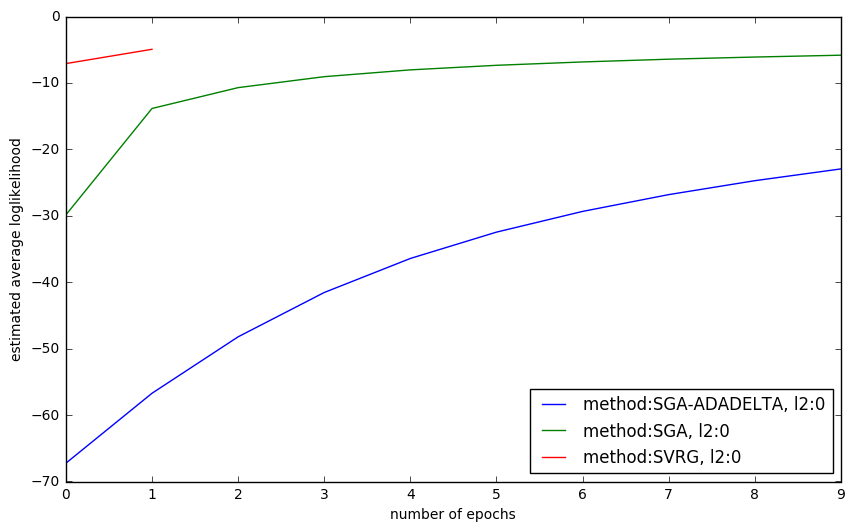

In [7]:
optimization_options = {"method" : "",
                        "regularization_type": "l2",
                        "regularization_value":0,
                        }
# train models using SGA, SGA-ADADELTA, and SVRG methods
trained_models_dir = {}
for fold in data_split:
    train_seqs_id = data_split[fold]['train']
    for method in ("SGA-ADADELTA", "SGA", "SVRG"):
        optimization_options['method'] = method
        if(method in {'SGA', 'SGA-ADADELTA'}):
            num_epochs = 10
        else:
            num_epochs = 2
        optimization_options['num_epochs'] = num_epochs
        print("trianing using optimization options:")
        print(optimization_options)
        # make sure we are initializing the weights to be 0
        crf_m.weights.fill(0)
        model_dir = workflow.train_model(train_seqs_id, crf_m, optimization_options)
        print("*"*50)
        avg_ll = ReaderWriter.read_data(os.path.join(model_dir, 'avg_loglikelihood_training'))
        plt.plot(avg_ll[1:], label="method:{}, {}:{}".format(optimization_options['method'], 
                                                     optimization_options['regularization_type'],
                                                     optimization_options['regularization_value']))
        trained_models_dir[method] = model_dir
    plt.legend(loc='lower right')
    plt.xlabel('number of epochs')
    plt.ylabel('estimated average loglikelihood')
    eval_options = {'model_eval':True,
                    'metric':'f1',
                    'seqs_info':workflow.seqs_info}

<a id="pseq_lbfgs_method"></a>

In [9]:
# use L-BFGS-B method for training
optimization_options = {"method" : "L-BFGS-B",
                        "regularization_type": "l2",
                        "regularization_value":0,
                        }
# start with 0 weights 
crf_m.weights.fill(0)
model_dir = workflow.train_model(train_seqs_id, crf_m, optimization_options)
trained_models_dir['L-BFGS-B'] = model_dir
print("*"*50)

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
success:  True
**************************************************


For the perceptron-based training methods, we use (<code class="pseq_code">COLLINS-PERCEPTRON</code>, <code class="pseq_code">SAPO</code>) for training CRFs model (<a href="#pseq_perceptrontraining_demo1">see code</a>). We specify the training to run for 10 epochs with full beam size (i.e. no pruning), and <code class="pseq_code">topK=5</code> (number of decoded sequences to use) for the <code class="pseq_code">SAPO</code> method. We also plot the estimated average decoding error for every epoch. We see that the decoding error is decreasing indicating the learning is performing well. The estimated average decoding error is dumped on disk in a file named <code class="pseq_code">avg_decodingerror_training</code> which is the equivalent to the <code class="pseq_code">avg_loglikelihood_training</code> file for the gradient-based methods. Another example using perceptron-based training is <a href="#pseq_perceptrontraining_demo2">provided in here</a>, where beam search (i.e pruning) with <code class="pseq_code">beam_size=5 </code>(i.e. keeping at most 5 labels at every position) with <code class="pseq_code">update_type=early</code> is used while decoding the sequences. Again, consult to <a href="#pseq_training_options"> the training table options</a> for exploring further training options.

<a id="pseq_perceptrontraining_demo1"></a>

trianing using optimization options:
{'topK': 1, 'num_epochs': 10, 'method': 'COLLINS-PERCEPTRON'}
sequences left 25
in full update routine ...
sequences left 24
in full update routine ...
sequences left 23
in full update routine ...
sequences left 22
in full update routine ...
sequences left 21
in full update routine ...
sequences left 20
in full update routine ...
sequences left 19
in full update routine ...
sequences left 18
in full update routine ...
sequences left 17
in full update routine ...
sequences left 16
in full update routine ...
sequences left 15
in full update routine ...
sequences left 14
in full update routine ...
sequences left 13
in full update routine ...
sequences left 12
in full update routine ...
sequences left 11
in full update routine ...
sequences left 10
in full update routine ...
sequences left 9
in full update routine ...
sequences left 8
in full update routine ...
sequences left 7
in full update routine ...
sequences left 6
in full update routine ...
seque

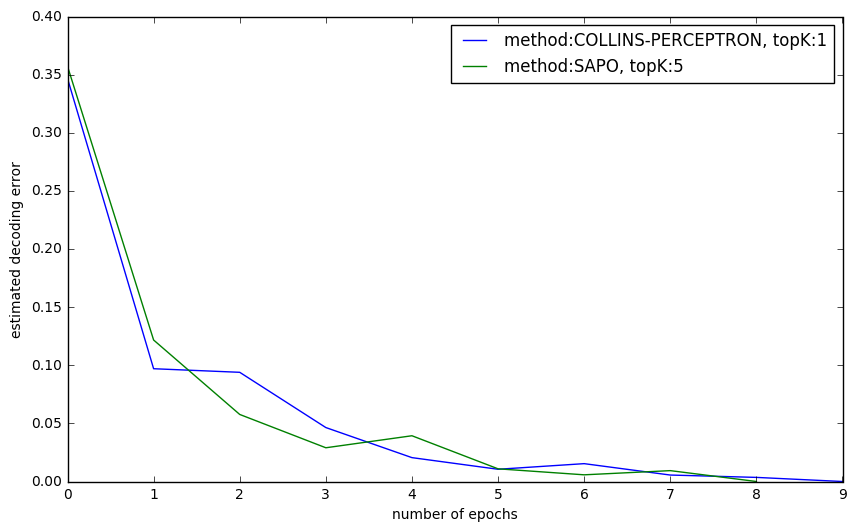

In [4]:
trained_models_dir = {}
optimization_options = {"method" : "",
                        "num_epochs":10
                        }
topK = 1
# train models using COLLINS-PERCEPTRON, SAPO
for fold in data_split:
    train_seqs_id = data_split[fold]['train']
    for method in ("COLLINS-PERCEPTRON", "SAPO"):
        optimization_options['method'] = method
        if(method == 'SAPO'):
            topK = 5
        optimization_options['topK'] = topK           
        print("trianing using optimization options:")
        print(optimization_options)
        # make sure we are initializing the weights to be 0
        crf_m.weights.fill(0)
        model_dir = workflow.train_model(train_seqs_id, crf_m, optimization_options)
        print("*"*50)
        avg_ll = ReaderWriter.read_data(os.path.join(model_dir, 'avg_decodingerror_training'))
        plt.plot(avg_ll[1:], label="method:{}, topK:{}".format(optimization_options['method'], topK))
        trained_models_dir[method] = model_dir
    plt.legend(loc='upper right')
    plt.xlabel('number of epochs')
    plt.ylabel('estimated decoding error')

<a id="pseq_perceptrontraining_demo2"></a>

trianing using optimization options:
{'beam_size': 5, 'method': 'COLLINS-PERCEPTRON', 'num_epochs': 10, 'update_type': 'early', 'topK': 1}
sequences left 25
in early update routine ...
sequences left 24
in early update routine ...
sequences left 23
in early update routine ...
sequences left 22
in early update routine ...
sequences left 21
in early update routine ...
sequences left 20
in early update routine ...
sequences left 19
in early update routine ...
sequences left 18
in early update routine ...
sequences left 17
in early update routine ...
sequences left 16
in early update routine ...
sequences left 15
in early update routine ...
sequences left 14
in early update routine ...
sequences left 13
in early update routine ...
sequences left 12
in early update routine ...
sequences left 11
in early update routine ...
sequences left 10
in early update routine ...
sequences left 9
in early update routine ...
sequences left 8
in early update routine ...
sequences left 7
in early update ro

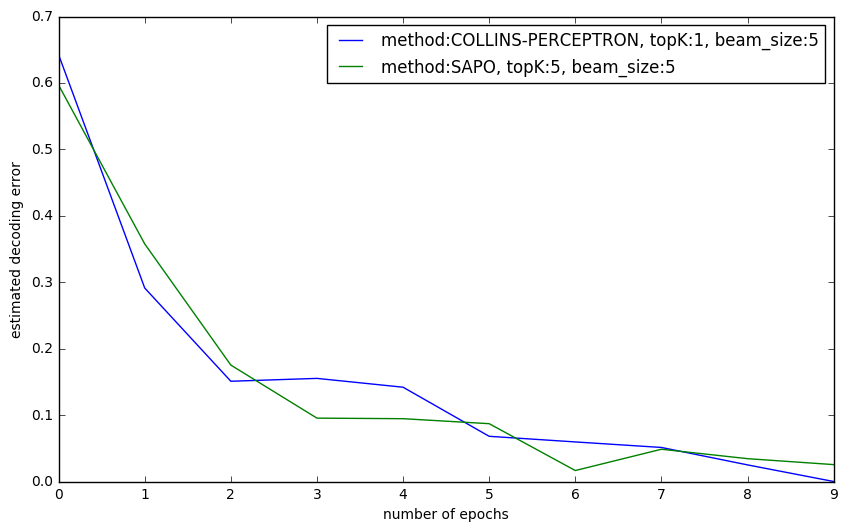

In [10]:
optimization_options = {"method" : "",
                        "num_epochs":10,
                        "beam_size":5,
                        "update_type":'early'
                        }
topK = 1
# train models using COLLINS-PERCEPTRON, SAPO
for fold in data_split:
    train_seqs_id = data_split[fold]['train']
    for method in ("COLLINS-PERCEPTRON", "SAPO"):
        optimization_options['method'] = method
        if(method == 'SAPO'):
            topK = 5
        optimization_options['topK'] = topK           
        print("trianing using optimization options:")
        print(optimization_options)
        # make sure we are initializing the weights to be 0
        crf_m.weights.fill(0)
        model_dir = workflow.train_model(train_seqs_id, crf_m, optimization_options)
        print("*"*50)
        avg_ll = ReaderWriter.read_data(os.path.join(model_dir, 'avg_decodingerror_training'))
        plt.plot(avg_ll[1:], label="method:{}, topK:{}, beam_size:5".format(optimization_options['method'], topK))
        trained_models_dir[method] = model_dir
    plt.legend(loc='upper right')
    plt.xlabel('number of epochs')
    plt.ylabel('estimated decoding error')

## 3.4 Using trained CRFs model

The final part of the workflow is to evaluate the trained models on test/validation sequences (i.e. sequences that we did not use for building and training the CRFs model). In our previous setup, we used all the sequences for training. We could still test the performance of the trained models on those sequences. Although, we are overfitting here, but it is worth to compare the different training methods using a performance measure. 

The method <code class="pseq_method">use_model(args)</code> in <code class="pseq_class">GenericWorkflowTrainer</code> class is used for: <br/>
<strong>A</strong>) reviving a trained model to decode sequences <br/>
<strong>B</strong>) writing the decoded sequences on a file and/or <br/>
<strong>C</strong>) evaluating the decoding performance based on a specified metric <br/>

The arguments for the <code class="pseq_method">use_model(args)</code> method are:

<strong>Args</strong>:
<ul>
<li><code class="pseq_args">savedmodel_dir</code>: the path to the trained model dumped on disk. In our setting/example, the <code class="pseq_var">trained_models_dir</code> contains the directory of the models we trained.</li>
<li><code class="pseq_args">options</code>: dictionary that specifies options needed to performs tasks (<strong>A</strong>, <strong>B</strong> and <strong>C</strong>). Generally, we have two scenarios:
<ul><li>If we already parsed and processed the sequences like in our example, then we use <code class="pseq_var">seqs_info</code> key passing the <code class="pseq_attr">seqs_info</code> instance attribute in our workflow trainer (<a href="#pseq_wft_seqsinfo_decoding">see code example</a>).<br/><br/>

<strong>Example</strong>: <br/><br/>

Sequences are parsed and processed (i.e. using seqs_info)
<pre style="font-size:0.74em">
options = {'seqs_info': dictionary comprising the processed info of the sequences saved on disk
           'seqbatch_size':integer, number of sequences in a batch to process 
           'model_eval': boolean, deciding if to evaluate performance
           'metric': {'f1', 'precision', 'recall', 'accuracy'},
           'exclude_states': list of labels to exclude form the decoding evaluation,
           'file_name': string, name of the file where decoded sequences will written on,
           'sep': string, separator between the columns 
                 (i.e. the tracks, reference label and predicted label when written on file) 
           'beam_size': integer, the number of states to keep while decoding with beam search
           }
</pre>
</li>
<li>If we have new sequences in a file, then we use <code class="pseq_args">seq_file</code> key passing the path to the file containing the sequences to decode (<a href="#pseq_wft_seqfile_decoding">see code example</a>).<br/><br/>

<strong>Example</strong>: <br/><br/>

Sequences are still in a file (i.e. using <code class="pseq_args">seq_file</code>)
<pre style="font-size:0.74em">
options = {'seqs_file': path to the sequences file
           'data_parser_options': dictionary stating the options to be used by the parser
                                  for reading the seqs_file (i.e. <a href="#pseq_seqfile_option">see here for more info</a>) 
           'seqbatch_size':integer, number of sequences in a batch to process 
           'model_eval': boolean, deciding if to evaluate performance
           'metric': {'f1', 'precision', 'recall', 'accuracy'},
           'exclude_states': list of labels to exclude form the decoding evaluation,
           'file_name': string, name of the file where decoded sequences will written on,
           'sep': string, separator between the columns
                 (i.e. the tracks, reference label and predicted label when written on file) 
           'beam_size': integer, the number of states to keep while decoding with beam search
           }
</pre>
</li>
</ul>

Another direct approach to used a trained CRFs model without the use of <code class="pseq_class">GenericWorkflowTrainer</code> class/subclass is to use <code class="pseq_method">generate_trained_model(args)</code> function found in the utilities module. The method takes the following arguments:

<ul><li><code class="pseq_args">model_parts_dir</code>: directory to the model_parts folder of a trained CRFs model (see here for a refresher)</li>
<li><code class="pseq_args">aextractor_obj</code>: initialized instance of class/subclass of <code class="pseq_class">GenericAttributeExtractor</code></li>
</ul>

Below is <a href="#pseq_reviveandusemodel_demo">an example</a> of reviving a trained model (the trained model used <code class="pseq_code">COLLINS-PERCEPTRON</code> method). Once, we have the revived model, it is ready to decode sequences. For that, we use the main decoding method  
<code class="pseq_method">decode_seqs(decoding_method, out_dir, **kwargs)</code> that takes two arguments and multiple keyword arguments (<a href="#pseq_reviveandusemodel_demo">see code for a demo</a>)
<br/>

Args:
<ol>
<li>
<code class="pseq_args">decoding_method</code>: string defining the decoding method. It is one of <code class="pseq_code">{'viterbi', 'per_state_decoding'}</code>. As not all decoders support <code class="pseq_code">'per_state_decoding'</code>, we primarily use <code class="pseq_code">'viterbi'</code> for now.
</li>
<li>
<code class="pseq_args">out_dir</code>: string representing the path to the output directory where sequence parsing takes place
</li>
</ol>
<br/>
For the keyword arguments, the main ones to specify are:<br/>

<ul>
<li>
We choose one of the following options <code class="pseq_code">{'seqs', 'seqs_dict', 'seqs_info'}</code>
<ul>
<li>
<code class="pseq_args">seqs</code>: list of sequences that are instances of <code class="pseq_class">SequenceStruct</code> class
</li>
<li><code class="pseq_args">seqs_dict</code>: a dictionary comprising of ids as keys (i.e. representing sequence ids) and corresponding sequences that are instances of <code class="pseq_class">SequenceStruct</code> class as values</li>

<li><code class="pseq_args">seqs_info</code>: dictionary containing the info about already parsed and processed sequences</li>
</ul></li>
<li>
<code class="pseq_args">file_name</code>: string representing the name of the file where the CRFs model writes the decoded sequences to (it is optional)
</li>
<li>
<code class="pseq_args">sep</code>: string representing separator between the columns/observations when writing decoded sequences on the specified file using <code class="pseq_args">file_name</code> keyword argument
</li>
</ul>

Now that we know how to revive a CRFs model and decode sequences, we need to evaluate how good is our decoding. This will be tackled using <code class="pseq_class">SeqDecodingEvaluator</code> class. Its constructor takes an instance of a CRFs model representation class (<a href="#pseq_crfmodels_repr_map">see this table</a> for a refresher). This is an <a href="#pseq_seqdecodingevaluator_class">example</a> demonstrating the use of <code class="pseq_class">SeqDecodingEvaluator</code> class for evaluating the decoded sequences of our revived model. In addition, it shows how to obtain confusion matrix for every decoded label/state.

<a id="pseq_wft_seqsinfo_decoding"></a>

In [11]:
# case of using seqs_info
# eval_options used:
# seqs_info since we already parsed and processed the sequences
# model_eval = True -- we need to evaluate model performance
# metric = f1 -- F1 score
# the other keys are not specified and hence by default, we will not write the decoded sequences to file 
# using full beam
use_options = {'seqs_info':workflow.seqs_info,
                'model_eval':True,
                'metric':'f1'
               }
print("Using seqs_info option")
for method, model_dir in trained_models_dir.items():
    perf = workflow.use_model(model_dir, use_options)
    print("model trained using {} method".format(method))
    metric_chosen = use_options['metric']
    print("metric:{}, value:{}".format(metric_chosen, perf[metric_chosen]))
    print()


Using seqs_info option
sequence decoded -- 24 sequences are left
sequence decoded -- 23 sequences are left
sequence decoded -- 22 sequences are left
sequence decoded -- 21 sequences are left
sequence decoded -- 20 sequences are left
sequence decoded -- 19 sequences are left
sequence decoded -- 18 sequences are left
sequence decoded -- 17 sequences are left
sequence decoded -- 16 sequences are left
sequence decoded -- 15 sequences are left
sequence decoded -- 14 sequences are left
sequence decoded -- 13 sequences are left
sequence decoded -- 12 sequences are left
sequence decoded -- 11 sequences are left
sequence decoded -- 10 sequences are left
sequence decoded -- 9 sequences are left
sequence decoded -- 8 sequences are left
sequence decoded -- 7 sequences are left
sequence decoded -- 6 sequences are left
sequence decoded -- 5 sequences are left
sequence decoded -- 4 sequences are left
sequence decoded -- 3 sequences are left
sequence decoded -- 2 sequences are left
sequence decoded --

<a id="pseq_wft_seqfile_decoding"></a>

In [6]:
train_file = os.path.join(dataset_dir, 'train.txt')
#case of using seq_file
# eval_options used:
# seq_file path to the CoNLL train.txt file
# data_parser_optoins dictionary to parse the train.txt file
# model_eval = True -- we need to evaluate model performance
# metric = f1 -- F1 score
# the other keys are not specified and hence by default, we will not write the decoded sequences to file 
# using full beam
parser_options = {'header': 'main', # main means the header is found in the first line of the file
                  'y_ref':True, # y_ref is a boolean indicating if the label to predict is already found in the file
                  'column_sep': " ",
                  'seg_other_symbol':None # spearator between the words/observations
                  }
use_options = {'seq_file':train_file,
               'data_parser_options':parser_options,
               'num_seqs':25,
               'model_eval':True,
               'metric':'f1'
              }
print("Using seq_file option")
for method, model_dir in trained_models_dir.items():
    perf = workflow.use_model(model_dir, use_options)
    print("model trained using {} method".format(method))
    metric_chosen = use_options['metric']
    print("metric:{}, value:{}".format(metric_chosen, perf[metric_chosen]))
    print()

Using seq_file option
identifying model active features -- processed seqs:  1
sequence decoded -- 0 sequences are left
f1 1.0
model trained using SAPO method
metric:f1, value:1.0

identifying model active features -- processed seqs:  1
sequence decoded -- 0 sequences are left
f1 0.972972972972973
model trained using COLLINS-PERCEPTRON method
metric:f1, value:0.972972972972973



<a id="pseq_reviveandusemodel_demo"></a>

In [7]:
print(trained_models_dir)
from pyseqlab.utilities import generate_trained_model
# revive a model that was trained using COLLINS-PERCEPTRON method
model_parts_dir = os.path.join(trained_models_dir['COLLINS-PERCEPTRON'], 'model_parts')
crf_percep = generate_trained_model(model_parts_dir, generic_attr_extractor)
print(crf_percep)
print()

# use viterbi for decoding
decoding_method = 'viterbi'
# use the same directory of the model
output_dir = trained_models_dir['COLLINS-PERCEPTRON']
# use tab as separator
sep = "\t"
decoded_sequences = crf_percep.decode_seqs(decoding_method, output_dir, seqs= seqs[:25], file_name = 'tutorial_seqs_decoding.txt', sep=sep)
print()
# display the decoded sequnces
for seq_id in decoded_sequences:
    print("seq_id ", seq_id)
    print("predicted labels:")
    print(decoded_sequences[seq_id]['Y_pred'])
    print("refernce labels:")
    print(decoded_sequences[seq_id]['seq'].flat_y)
    print("-"*50)

{'SAPO': '/Users/mombelli/Documents/eclipse_mars_workspace/pyseqlab_exp/tutorials/working_dir/models/2017_5_18-0_16_8_233464', 'COLLINS-PERCEPTRON': '/Users/mombelli/Documents/eclipse_mars_workspace/pyseqlab_exp/tutorials/working_dir/models/2017_5_18-0_15_52_475608'}

identifying model active features -- processed seqs:  1
identifying model active features -- processed seqs:  2
identifying model active features -- processed seqs:  3
identifying model active features -- processed seqs:  4
identifying model active features -- processed seqs:  5
identifying model active features -- processed seqs:  6
identifying model active features -- processed seqs:  7
identifying model active features -- processed seqs:  8
identifying model active features -- processed seqs:  9
identifying model active features -- processed seqs:  10
identifying model active features -- processed seqs:  11
identifying model active features -- processed seqs:  12
identifying model active features -- processed seqs:  13

<a id="pseq_seqdecodingevaluator_class"></a>

In [8]:
from pyseqlab.crf_learning import SeqDecodingEvaluator
# initialize an evaluator
evaluator = SeqDecodingEvaluator(crf_percep.model)
# evaluate performance 
Y_seqs_dict = GenericTrainingWorkflow.map_pred_to_ref_seqs(decoded_sequences)
taglevel_perf = evaluator.compute_states_confmatrix(Y_seqs_dict)
perf = evaluator.get_performance_metric(taglevel_perf, "f1", exclude_states=[])
perf = evaluator.get_performance_metric(taglevel_perf, "precision", exclude_states=[])
perf = evaluator.get_performance_metric(taglevel_perf, "recall", exclude_states=[])
perf = evaluator.get_performance_metric(taglevel_perf, "accuracy", exclude_states=[])
print()
# demonstrate confusion matrix per label/state
taglevel_conf_matrix = perf['taglevel_confusion_matrix']
for state, code in crf_percep.model.Y_codebook.items():
    print("confusion_matrix for state={}: ".format(state))
    print(taglevel_conf_matrix[code])
    print("-"*40)

NameError: name 'crf_percep' is not defined

# 4. Applications

There are still many aspects to explore and experiment with. We show the potentials of the package by developing [applications](/applications) in three different areas:
<ol>
<li>Natural language processing (i.e. shallow parsing, part-of-speech tagging, bio-medical named entity recognition)</li>
<li>Wearable and sensor measurement sequences (human activity recognition)</li>
<li>Classification of Eukaryotic splice-junction sequences</li>
</ol>

Each application has its own repository including notebook tutorials showing the:
<ul>
<li> statement of the problem</li>
<li> model building and training procedure</li>
<li> evaluation of the decoding performance </li>
<li> process of reviving and using the trained models </li>
</ul>




# 5. References & relevant literature

Bottou, L., & Le Cun, Y. (2004). Large Scale Online Learning. Advances in Neural Information Processing Systems, 16, 217–225.

Collins, M. (2002). Discriminative training methods for hidden Markov models: theory and experiments with perceptron algorithms. In Proceedings of the ACL-02 conference on Empirical methods in natural language processing - EMNLP ’02 (pp. 1–8). doi:10.3115/1118693.1118694

Cuong, V. N., Ye, N., Lee, W. S., & Chieu, H. L. (2014). Conditional Random Field with High-order Dependencies for Sequence Labeling and Segmentation. Journal of Machine Learning Research, 15, 981–1009.
Huang, L., Fayong, S., & Guo, Y. (2012). Structured perceptron with inexact search. 2012 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, 142–151. Retrieved from http://dl.acm.org/citation.cfm?id=2382029.2382049

Johnson, R., & Zhang, T. (2013). Accelerating Stochastic Gradient Descent using Predictive Variance Reduction. Advances in Neural Information Processing Systems 26, 1(3), 315–323. 

Kim, J.-D., Ohta, T., Tsuruoka, Y., Tateisi, Y., & Collier, N. (2004). Introduction to the Bio-entity Recognition Task at JNLPBA. Proceedings of the International Joint Workshop on Natural Language Processing in Biomedicine and Its Applications, 70–75. doi:10.3115/1567594.1567610

Lafferty, J., McCallum, A., & Pereira, F. C. N. (2001). Conditional random fields: Probabilistic models for segmenting and labeling sequence data. ICML ’01 Proceedings of the Eighteenth International Conference on Machine Learning, 8(June), 282–289. doi:10.1038/nprot.2006.61

Sarawagi, S., & Cohen, W. W. (2005). Semi-Markov Conditional Random Fields for Information Extraction. Advances in Neural Information Processing Systems, 1185–1192. doi:10.1.1.128.3524

Soong, F. K., & Huang, E.-F. (1990). A tree-trellis based fast search for finding the N Best sentence hypotheses in continuous speech recognition. Proceedings of the Workshop on Speech and Natural Language - HLT ’90, 12–19. doi:10.3115/116580.116591

Sun, X. (2015). Towards Shockingly Easy Structured Classification: A Search-based Probabilistic Online Learning Framework. Retrieved from http://arxiv.org/abs/1503.08381

Tsuruoka, Y., Tsujii, J., & Ananiadou, S. (2009). Stochastic gradient descent training for L1-regularized log-linear models with cumulative penalty. Proceedings of the Joint Conference of the 47th Annual Meeting of the ACL and the 4th International Joint Conference on Natural Language Processing of the AFNLP, 1, 477. doi:10.3115/1687878.1687946
Vieira, T., Cotterell, R., & Eisner, J. (2016). Speed-Accuracy Tradeoffs in Tagging with Variable-Order CRFs and Structured Sparsity. In EMNLP.

Viterbi, A. (1967). Error bounds for convolutional codes and an asymptotically optimum decoding algorithm. IEEE Transactions on Information Theory, 13(2), 260–269. doi:10.1109/TIT.1967.1054010
Ye, N., Lee, W. S., Chieu, H. L., & Wu, D. (2009). Conditional Random Fields with High-Order Features for Sequence Labeling. Neural Information Processing Systems, 2, 2. Retrieved from http://www.comp.nus.edu.sg/~leews/publications/nips09_paper.pdf

Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method. Retrieved from http://arxiv.org/abs/1212.5701

